# Don't Overfit! II

## 0. Importing libraries

In [1]:
import matplotlib
matplotlib.use('Agg')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.datasets as datasets
import csv
import lightgbm as lgb

from feature_selector import FeatureSelector

np.random.seed(7)


## 1. Reading the dataset

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
print ('Size of the training data: ', train.shape)
print ('Size of the testing data: ', test.shape)

Size of the training data:  (250, 302)
Size of the testing data:  (19750, 301)


## 2. Displaying the dataset header

In [3]:
train.head(5)

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,...,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,...,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,...,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


## 3. Setting up the dataframe

In [4]:

train = train.drop(['id'], axis = 1)
test = test.drop(['id'], axis = 1)


In [5]:
from sklearn.model_selection import train_test_split

y = train['target']
X = train.drop(['target'],1)

X, garboX, y, garboY = train_test_split(X, y, test_size=0.75)

trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.30)



df = pd.DataFrame(np.c_[train.drop(['target'],1), train['target']])
fs = FeatureSelector(data = train, labels = train.pop('target'))



print("Dataframes set.")
df.head(5)


Dataframes set.


,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,-2.246,1.825,...,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065,1.0
1,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,0.004,-0.291,...,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973,0.0
2,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,0.137,0.183,...,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211,1.0
3,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,0.503,0.274,...,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238,1.0
4,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,-0.012,2.198,...,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253,1.0


## 4. Visualizing the data

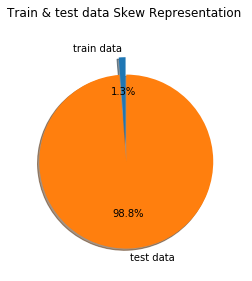

In [6]:
%matplotlib inline
pie_labels = 'train data', 'test data'
pie_sizes = [train.shape[0], test.shape[0]]
pie_explode = (0.2, 0)
plt.title('Train & test data Skew Representation \n \n')
plt.pie(pie_sizes, explode=pie_explode, labels=pie_labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Histograms of the first 20 features


C:\Users\hecto\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


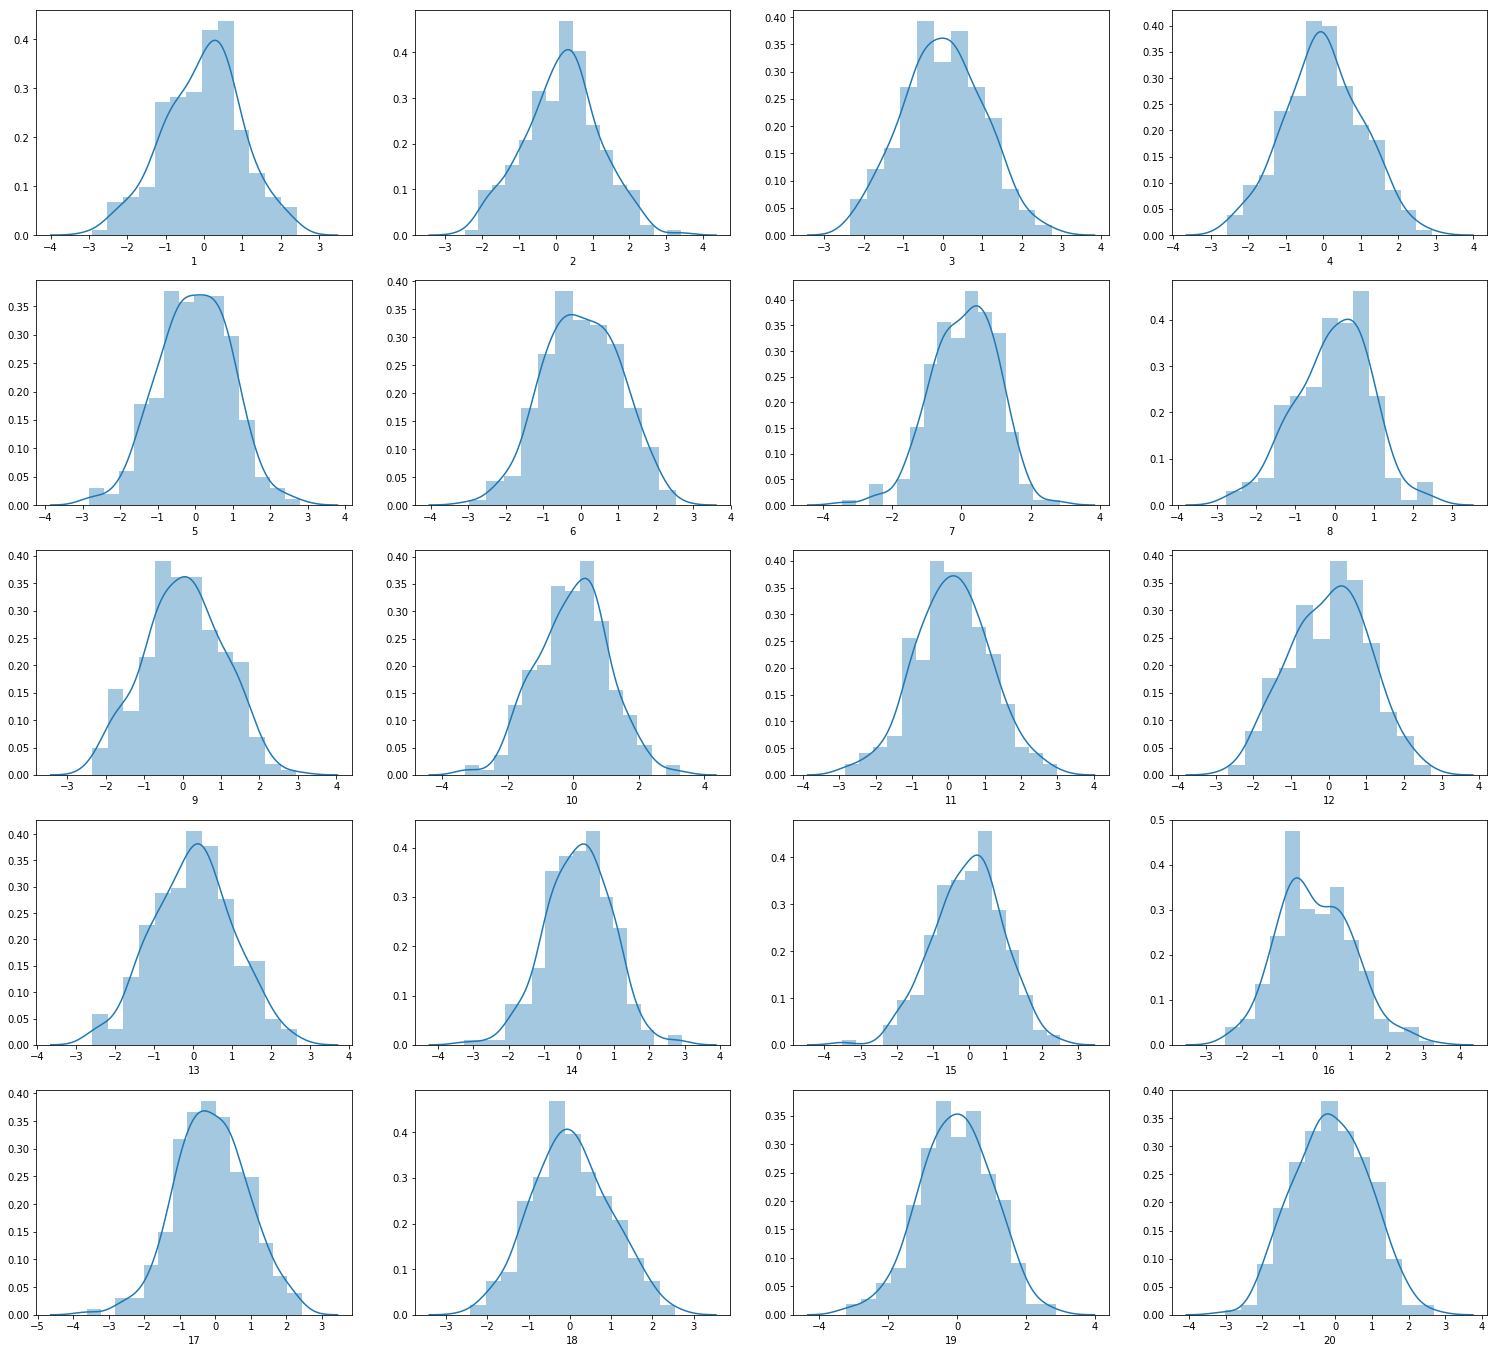

In [7]:

print('Histograms of the first 20 features')

plt.figure(figsize=(26, 24))
for i in range(1, 21):
    plt.subplot(5, 4, i)
    sns_plot = sns.distplot(df[i])


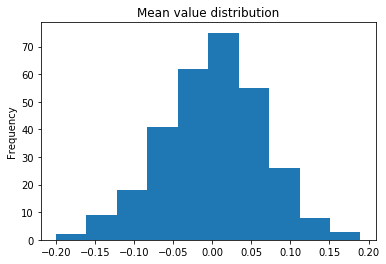

In [8]:
train[train.columns[1:]].mean().plot('hist');
plt.title('Mean value distribution');

In [9]:
fs.identify_collinear(correlation_threshold=0.5)
correlated_features = fs.ops['collinear']


0 features with a correlation magnitude greater than 0.50.



In [10]:
fs.identify_missing(missing_threshold=0)
print("No missing values in the data.")

0 features with greater than 0.00 missing values.

No missing values in the data.


## 5. Analysing features

In [11]:
fs.identify_zero_importance(task = 'classification',
                            eval_metric = 'auc',
                            n_iterations = 10,
                            early_stopping = True
                           )

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.537296	valid_0's auc: 0.777778
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.624761	valid_0's auc: 0.651786
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.581044	valid_0's auc: 0.764881
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.583063	valid_0's auc: 0.74359
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.552059	valid_0's auc: 0.767857
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.574144	valid_0's auc: 0.74

In [12]:
zero_importance_features = fs.ops['zero_importance']
print ('The zero important features are: ', zero_importance_features)

The zero important features are:  ['286', '274', '291', '260', '265', '283', '150', '248', '60', '107', '105', '94', '92', '88', '84', '75', '67', '61', '53', '243', '47', '37', '36', '34', '23', '22', '11', '10', '5', '109', '116', '124', '128', '240', '238', '229', '223', '220', '218', '216', '213', '206', '190', '178', '175', '174', '171', '170', '169', '158', '155', '138', '299']


In [13]:
fs.identify_low_importance(cumulative_importance = 0.90)
low_importance_features = fs.ops['low_importance']
print('The low important features (least contributing towards the 99% of the total importance) are: \n', low_importance_features)

136 features required for cumulative importance of 0.90 after one hot encoding.
164 features do not contribute to cumulative importance of 0.90.

The low important features (least contributing towards the 99% of the total importance) are: 
 ['46', '51', '8', '284', '110', '68', '269', '41', '180', '182', '292', '254', '185', '268', '12', '3', '236', '191', '192', '198', '200', '28', '205', '207', '26', '231', '212', '230', '19', '167', '233', '270', '153', '142', '118', '120', '77', '280', '143', '141', '122', '102', '66', '79', '49', '119', '156', '98', '97', '288', '135', '95', '58', '163', '57', '287', '221', '259', '15', '13', '21', '168', '78', '74', '294', '103', '4', '257', '256', '99', '242', '255', '246', '247', '93', '89', '251', '130', '55', '263', '181', '293', '146', '52', '186', '184', '290', '273', '193', '44', '39', '267', '161', '162', '172', '211', '144', '32', '139', '166', '136', '137', '264', '31', '27', '202', '140', '29', '197', '196', '10', '5', '109', '116', '1

In [14]:
print ('Most important features:')
fs.feature_importances.head(10)

Most important features:


,feature,importance,normalized_importance,cumulative_importance
0,33,19.5,0.114976,0.114976
1,65,11.0,0.064858,0.179835
2,91,6.5,0.038325,0.218160
3,217,6.3,0.037146,0.255307
4,117,5.6,0.033019,0.288325
5,199,4.0,0.023585,0.311910
6,295,4.0,0.023585,0.335495
7,16,2.5,0.014741,0.350236
8,108,2.2,0.012972,0.363208
9,134,2.1,0.012382,0.375590


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input,Dense
from keras.models import Model,Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
np.random.seed(7)

Using TensorFlow backend.


## 6. Training the autoencoder

The following cell contains the gridsearch functionality that was originally used to tune the autoencoder

In [16]:




# def create_autoencoder(layers, activation):

#     input_dim=train.shape[1]
#     encoding_dim=layers
#     compression_factor=float(input_dim/encoding_dim)

#     autoencoder=Sequential()
#     autoencoder.add(Dense(encoding_dim, input_shape=(input_dim,),activation='relu'))
#     autoencoder.add(Dense(input_dim,activation=activation))

#     input_img=Input(shape=(input_dim,))
#     encoder_layer=autoencoder.layers[0]
#     encoder=Model(input_img,encoder_layer(input_img))

#     autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
#     return autoencoder
# Kregressor_autoencoder = KerasRegressor(build_fn=create_autoencoder, verbose=0)
# # autoencoder.fit(train,train,epochs=100, batch_size=256, shuffle=True, validation_data=(test,test))

# thin_dimension = [300, 600]
# activations = ['sigmoid']
# batches = [128]
# num_epochs = [100]

# param_grid = dict(layers = thin_dimension, activation=activations, batch_size=batches, epochs=num_epochs)
# grid = GridSearchCV(estimator = Kregressor_autoencoder, param_grid=param_grid, scoring='neg_mean_squared_error')


In [17]:
np.random.seed(7)
input_dim=trainX.shape[1]

# this is the size of our encoded representations
encoding_dim = 100  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_data = Input(shape=(input_dim,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_data)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_data, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_data, encoded)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(trainX, trainX,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(testX, testX))

Train on 43 samples, validate on 19 samples
Epoch 1/100
43/43 [==============================] - 8s 190ms/step - loss: 0.7478 - val_loss: 0.7263
Epoch 2/100
43/43 [==============================] - 0s 256us/step - loss: 0.7190 - val_loss: 0.7083
Epoch 3/100
43/43 [==============================] - 0s 233us/step - loss: 0.6913 - val_loss: 0.6909
Epoch 4/100
43/43 [==============================] - 0s 186us/step - loss: 0.6647 - val_loss: 0.6740
Epoch 5/100
43/43 [==============================] - 0s 231us/step - loss: 0.6388 - val_loss: 0.6576
Epoch 6/100
43/43 [==============================] - 0s 185us/step - loss: 0.6135 - val_loss: 0.6416
Epoch 7/100
43/43 [==============================] - 0s 257us/step - loss: 0.5885 - val_loss: 0.6260
Epoch 8/100
43/43 [==============================] - 0s 235us/step - loss: 0.5637 - val_loss: 0.6108
Epoch 9/100
43/43 [==============================] - 0s 235us/step - loss: 0.5390 - val_loss: 0.5957
Epoch 10/100
43/43 [===========================

Epoch 81/100
43/43 [==============================] - 0s 139us/step - loss: -2.8656 - val_loss: -0.0899
Epoch 82/100
43/43 [==============================] - 0s 139us/step - loss: -2.9306 - val_loss: -0.0965
Epoch 83/100
43/43 [==============================] - 0s 139us/step - loss: -2.9954 - val_loss: -0.1031
Epoch 84/100
43/43 [==============================] - 0s 162us/step - loss: -3.0599 - val_loss: -0.1094
Epoch 85/100
43/43 [==============================] - 0s 139us/step - loss: -3.1238 - val_loss: -0.1156
Epoch 86/100
43/43 [==============================] - 0s 109us/step - loss: -3.1870 - val_loss: -0.1215
Epoch 87/100
43/43 [==============================] - 0s 162us/step - loss: -3.2494 - val_loss: -0.1274
Epoch 88/100
43/43 [==============================] - 0s 141us/step - loss: -3.3117 - val_loss: -0.1332
Epoch 89/100
43/43 [==============================] - 0s 139us/step - loss: -3.3736 - val_loss: -0.1387
Epoch 90/100
43/43 [==============================] - 0s 139us/s

## 7. Encoding the features

In [18]:
enc_trainX = encoder.predict(trainX)
enc_testX = encoder.predict(testX)

## 8. Training the predictor

Train on 43 samples, validate on 19 samples
Epoch 1/100
43/43 [==============================] - 1s 14ms/step - loss: 0.7205 - acc: 0.4186 - val_loss: 0.7059 - val_acc: 0.4211
Epoch 2/100
43/43 [==============================] - 0s 393us/step - loss: 0.7089 - acc: 0.3953 - val_loss: 0.6995 - val_acc: 0.4211
Epoch 3/100
43/43 [==============================] - 0s 394us/step - loss: 0.6962 - acc: 0.5581 - val_loss: 0.6934 - val_acc: 0.5263
Epoch 4/100
43/43 [==============================] - 0s 231us/step - loss: 0.6835 - acc: 0.6279 - val_loss: 0.6877 - val_acc: 0.5789
Epoch 5/100
43/43 [==============================] - 0s 232us/step - loss: 0.6713 - acc: 0.5814 - val_loss: 0.6826 - val_acc: 0.6316
Epoch 6/100
43/43 [==============================] - 0s 233us/step - loss: 0.6597 - acc: 0.6977 - val_loss: 0.6781 - val_acc: 0.6316
Epoch 7/100
43/43 [==============================] - 0s 186us/step - loss: 0.6490 - acc: 0.7209 - val_loss: 0.6742 - val_acc: 0.6316
Epoch 8/100
43/43 [=======

Epoch 62/100
43/43 [==============================] - 0s 278us/step - loss: 0.4434 - acc: 0.7209 - val_loss: 0.6803 - val_acc: 0.6316
Epoch 63/100
43/43 [==============================] - 0s 277us/step - loss: 0.4404 - acc: 0.7209 - val_loss: 0.6807 - val_acc: 0.6316
Epoch 64/100
43/43 [==============================] - 0s 231us/step - loss: 0.4374 - acc: 0.7209 - val_loss: 0.6812 - val_acc: 0.6316
Epoch 65/100
43/43 [==============================] - 0s 254us/step - loss: 0.4343 - acc: 0.7442 - val_loss: 0.6816 - val_acc: 0.6316
Epoch 66/100
43/43 [==============================] - 0s 210us/step - loss: 0.4312 - acc: 0.7442 - val_loss: 0.6821 - val_acc: 0.6316
Epoch 67/100
43/43 [==============================] - 0s 235us/step - loss: 0.4281 - acc: 0.7674 - val_loss: 0.6825 - val_acc: 0.6316
Epoch 68/100
43/43 [==============================] - 0s 194us/step - loss: 0.4250 - acc: 0.7674 - val_loss: 0.6829 - val_acc: 0.6316
Epoch 69/100
43/43 [==============================] - 0s 231us

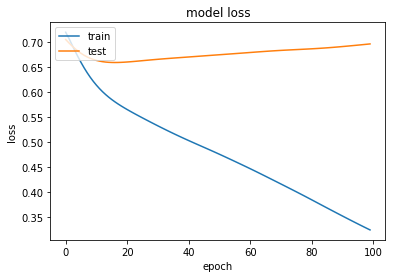

19/19 [==============================] - 0s 210us/step

 Training acc :  93.02325650703075 %

 Validation acc :  63.15789222717285 %


In [19]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
# fix random seed for reproducibility
np.random.seed(7)
# split into input (X) and output (Y) variables
input_dim=enc_trainX.shape[1]
output_dim=trainy.ndim
# create model
model = Sequential()
model.add(Dense(50,  input_shape=(input_dim,),  activation='sigmoid'))
model.add(Dense(10,  activation='sigmoid'))
model.add(Dense(output_dim, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Early stopping
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
# Fit the model
history = model.fit(x = enc_trainX, y = trainy,
                  epochs=100, 
                  batch_size=256,
                  shuffle=True,
                  validation_data=(enc_testX, testy))

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# evaluate the model
Tra_scores = model.evaluate(enc_trainX, trainy)
Val_scores = model.evaluate(enc_testX, testy)
tra_accuracy = Tra_scores[1]*100
val_accuracy = Val_scores[1]*100
accuracy_name = model.metrics_names[1]
print('\n Training', accuracy_name, ': ', tra_accuracy, '%')
print('\n Validation', accuracy_name, ': ', val_accuracy, '%')

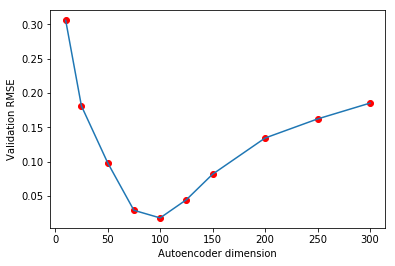

In [20]:

# The following data has been obtained through trial and error
axis1=[[10, 0.3059],
       [25, 0.1811],
       [50, 0.0983],
       [75, 0.0290],
       [100, -0.0179],
       [125, -0.0444],
       [150, -0.0816],
       [200, -0.1343],
       [250, -0.1621],
       [300, -0.1852]]


def RMSE(num1):
    num2 = sqrt()

axis1 = np.transpose(axis1)
plt.plot(axis1[0], np.absolute(axis1[1]), 'ro')
plt.plot(axis1[0], np.absolute(axis1[1]))

plt.ylabel('Validation RMSE')
plt.xlabel('Autoencoder dimension')
plt.show()

## 9. Plotting the results

Please note: The following results were manually obtained through manual iteration on each of the three separate notebooks. They are annotated and grouped here to produce the final graph that appears in the report.
    

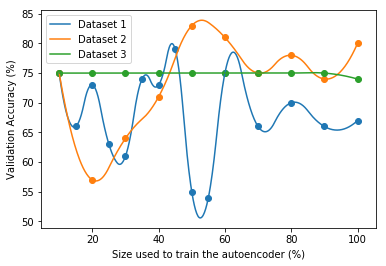

In [21]:
from scipy.interpolate import interp1d

# The following data has been obtained for this first dataset:
axis1=[[10, 75],
       [15, 66],
       [20, 73],
       [25, 63],
       [30, 61],
       [35, 74],
       [40, 73],
       [45, 79],
       [50, 55],
       [55, 54],
       [60, 75],
       [70, 66],
       [80, 70],
       [90, 66],
       [100, 67]]

# The following data has been obtained for the second dataset:
axis2=[[10, 75],
       [20, 57],
       [30, 64],
       [40, 71],
       [50, 83],
       [60, 81],
       [70, 75],
       [80, 78],
       [90, 74],
       [100, 80]]

# The following data has been obtained for the third dataset:
axis3=[[10, 75],
       [20, 75],
       [30, 75],
       [40, 75],
       [50, 75],
       [60, 75],
       [70, 75],
       [80, 75],
       [90, 75],
       [100, 74]]

x1 = np.transpose(axis1)[0]
y1 = np.transpose(axis1)[1]
    
x1_new = np.linspace(x1.min(), x1.max(),500)

f1 = interp1d(x1, y1, kind='quadratic')
y1_smooth=f1(x1_new)
    
x2 = np.transpose(axis2)[0]
y2 = np.transpose(axis2)[1]
    
x2_new = np.linspace(x2.min(), x2.max(),500)

f2 = interp1d(x2, y2, kind='quadratic')
y2_smooth=f2(x2_new)

x3 = np.transpose(axis3)[0]
y3 = np.transpose(axis3)[1]
    
x3_new = np.linspace(x3.min(), x3.max(),500)

f3 = interp1d(x3, y3, kind='quadratic')
y3_smooth=f3(x3_new)

plt.plot (x1_new,y1_smooth, label='Dataset 1')
plt.scatter (x1, y1)

plt.plot (x2_new,y2_smooth, label='Dataset 2')
plt.scatter (x2, y2)

plt.plot (x3_new,y3_smooth, label='Dataset 3')
plt.scatter (x3, y3)

plt.legend()
plt.ylabel('Validation Accuracy (%)')
plt.xlabel('Size used to train the autoencoder (%)')
plt.show()

